In [1]:
## IMPORTS
import sys
sys.path.append('C:\\Users\\user\\Desktop\\Globant\\nfs-npl-globant-test-2024\\src\\data')
sys.path.append('C:\\Users\\user\\Desktop\\Globant\\nfs-npl-globant-test-2024\\src\\features')

In [2]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from clustering import Cluster
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# sys.path.append('C:/Users/user/Documents/LOKA_Test/LOKA_TECNICAL_TEST_V0/test')

c:\Users\user\Desktop\Globant\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
## Connecting to the api with my keys
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

df = pd.read_csv('C:/Users/user/Desktop/Globant/nfs-npl-globant-test-2024/data/processed/train_data.csv').fillna("")
df.drop(['cluster', 'abstract_length', 'abstract'], axis=1, inplace=True)

df.head()

,title,clean_abstract
0,NSF Postdoctoral Fellowship in Biology FY 2020,this action funds an nsf postdoctoral research...
1,PFI-TT: Bridging the Information Gap in Supply...,the broader impactcommercial potential of this...
2,Mechanisms of viral protein trafficking in pol...,arthropods represent the largest animal biomas...
3,Preparing Secondary Teachers to Teach Quantum ...,the national quantum initiative act nqia was s...
4,FoMR: Microarchitecture mechanisms for handlin...,computers are playing a continually increasing...


In [6]:
# Embeddings sets
embeddings_model = OpenAIEmbeddings(api_key=OPENAI_API_KEY)

In [7]:
# Generate embeddings for titles
titles = df['clean_abstract'].tolist()
embeddings = [embeddings_model.embed_query(title) for title in titles]

In [8]:
# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings)

In [9]:
# View
embeddings[0][:10]

[-0.00424086581915617,
 -0.010150155052542686,
 -0.011930271051824093,
 -0.025521984323859215,
 -0.02168251760303974,
 0.018010590225458145,
 -0.022617951035499573,
 0.0005558500997722149,
 -0.0125027010217309,
 -0.018513211980462074]

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Resumen estadístico
# rows, cols = embeddings.shape
# num_nonzeros = np.count_nonzero(embeddings)
# density = num_nonzeros / (rows * cols)
# print(f"Número de elementos no cero: {num_nonzeros}")
# print(f"Densidad: {density:.4f}")

# # Submatriz para heatmap
# submatrix_size = 100  # Tamaño de la submatriz
# submatrix = embeddings[:submatrix_size, :submatrix_size]

# plt.figure(figsize=(10, 8))
# sns.heatmap(submatrix, cmap='viridis', cbar=True)
# plt.title('Heatmap de una submatriz de 100x100')
# plt.show()

# # Diagrama de dispersión de elementos no cero
# row, col = np.nonzero(embeddings)
# plt.figure(figsize=(10, 8))
# plt.scatter(col, row, marker='.', color='blue', s=1)
# plt.gca().invert_yaxis()
# plt.title('Diagrama de dispersión de elementos no cero')
# plt.xlabel('Columnas')
# plt.ylabel('Filas')
# plt.show()

# # Histograma de valores no cero
# plt.figure(figsize=(10, 8))
# plt.hist(embeddings[embeddings != 0], bins=50, color='blue', edgecolor='black')
# plt.title('Histograma de valores no cero')
# plt.xlabel('Valor')
# plt.ylabel('Frecuencia')
# plt.show()


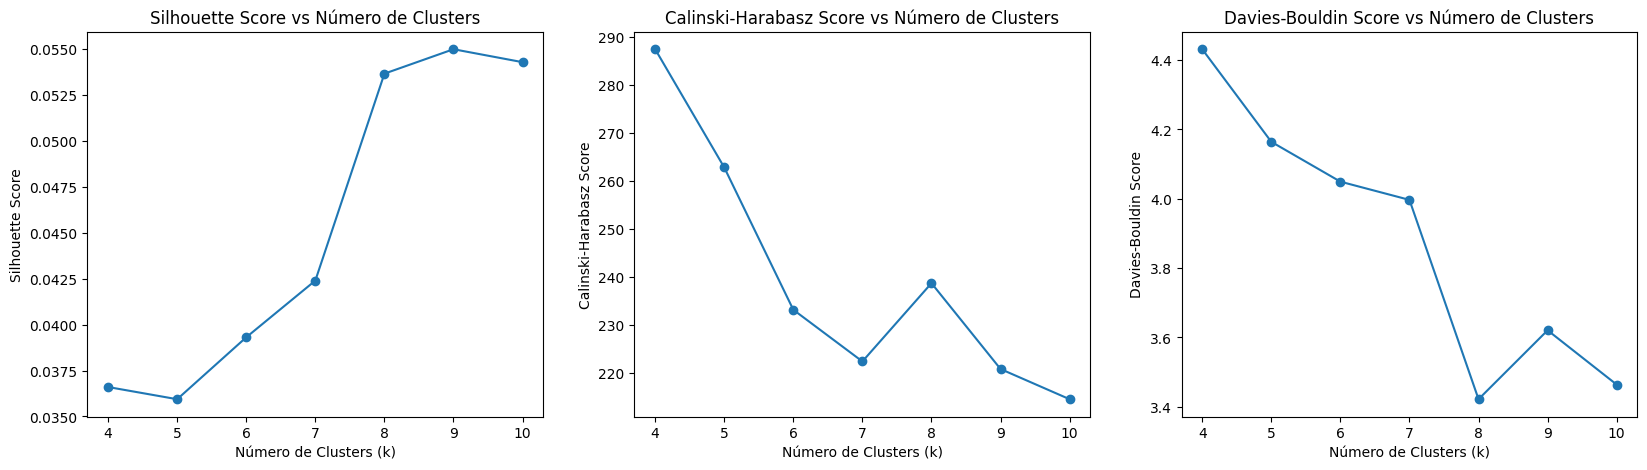

In [15]:
## Analysis of k optimal clusters
cl = Cluster()
sparse_matrix = csr_matrix(embeddings)
cl.find_optimal_k(sparse_matrix, start_k=4, end_k=10, random_state=42)

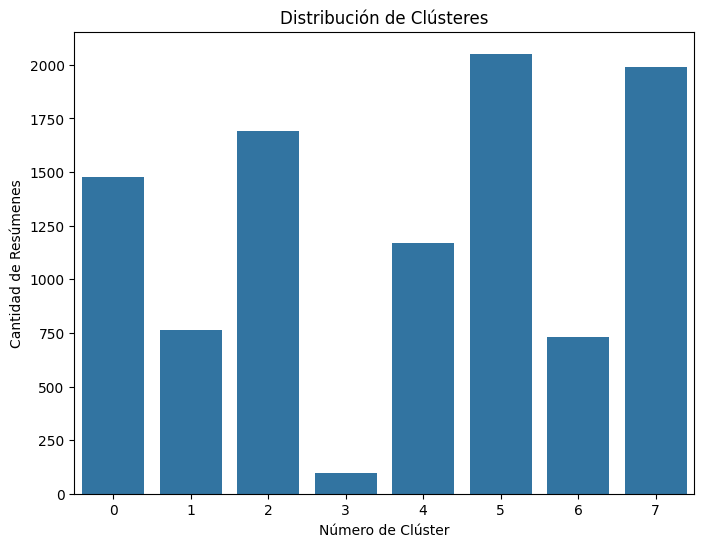

,title,cluster
0,NSF Postdoctoral Fellowship in Biology FY 2020,4
1,PFI-TT: Bridging the Information Gap in Supply...,1
2,Mechanisms of viral protein trafficking in pol...,4
3,Preparing Secondary Teachers to Teach Quantum ...,2
4,FoMR: Microarchitecture mechanisms for handlin...,5


In [18]:
# Configure K-Means
k = 8 # Number of clusters, can be adjusted as needed
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(embeddings)

# Assign the clusters to each summary
df['cluster'] = kmeans.labels_

# Visualization of cluster distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', data=df)
plt.title('Distribución de Clústeres')
plt.xlabel('Número de Clúster')
plt.ylabel('Cantidad de Resúmenes')
plt.show()

df[['title', 'cluster']].head()

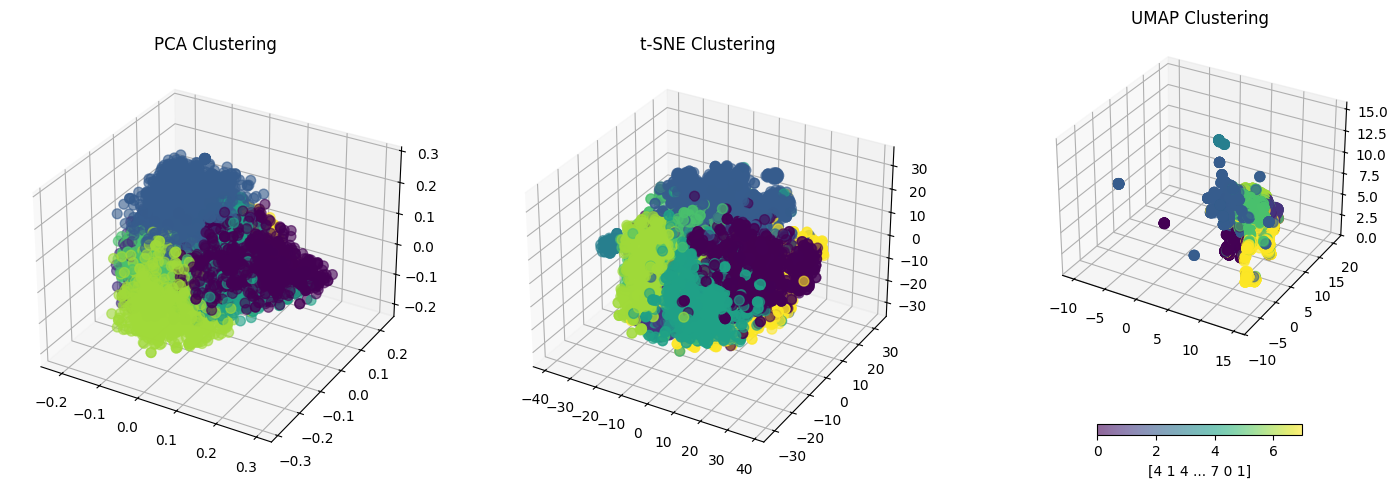

In [19]:
cl.visualize_clusters_3d(sparse_matrix, kmeans.labels_,kmeans.labels_,best_k=8)

In [21]:
df[['clean_abstract','cluster']].groupby(['cluster']).count()

,clean_abstract
cluster,
0,1478
1,764
2,1692
3,96
4,1170
5,2052
6,733
7,1990


In [23]:
# Reduce dimensionality to 3D for visualization
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(sparse_matrix.toarray())

# Create a DataFrame for display
df_viz = pd.DataFrame(reduced_features, columns=['PC1', 'PC2', 'PC3'])
df_viz['cluster'] = kmeans.labels_

# Get the number of points in each cluster
cluster_counts = df_viz['cluster'].value_counts().sort_index().reset_index()
cluster_counts.columns = ['cluster', 'count']

# Merge cluster_counts with df_viz
df_viz = pd.merge(df_viz, cluster_counts, on='cluster')

# Scatter plot of 3D clusters using Plotly
fig = px.scatter_3d(
        df_viz, x='PC1', y='PC2', z='PC3', color='cluster',  title='Visualización de los Clústeres con PCA en 3D',
        labels={
            'PC1': 'Componente Principal 1', 
            'PC2': 'Componente Principal 2', 
            'PC3': 'Componente Principal 3'
        },
        hover_data={'cluster': True, 'count': True}, color_continuous_scale=px.colors.qualitative.Set1)

# Add title and tags
fig.update_traces(marker=dict(size=3), selector=dict(mode='markers'))

fig.update_layout(
        scene=dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend_title='Cluster'
)

fig.show()

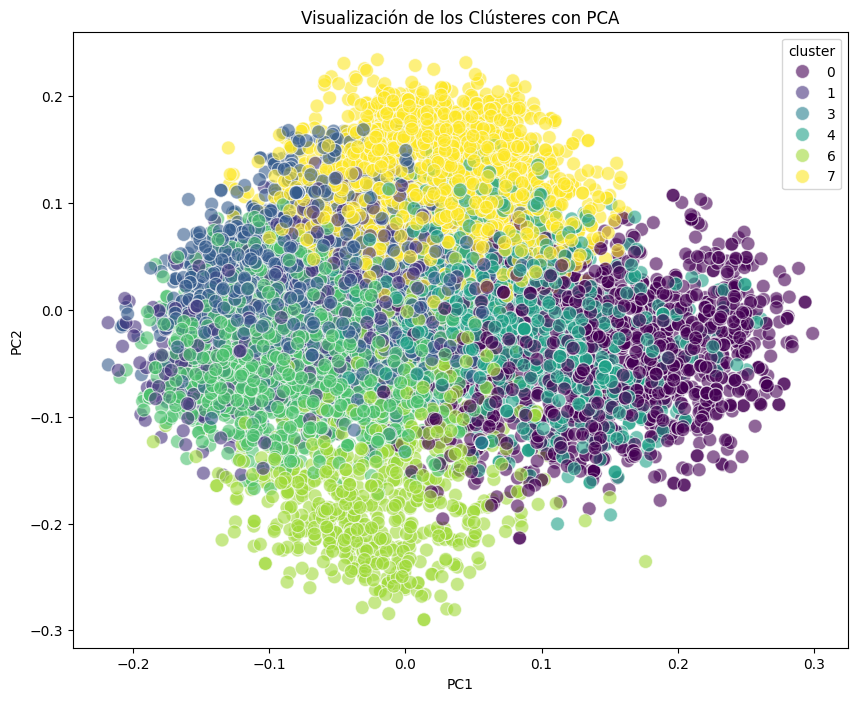

In [24]:
# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(sparse_matrix.toarray())

# Create a DataFrame for display
df_viz = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
df_viz['cluster'] = kmeans.labels_

# Cluster scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=df_viz, s=100, alpha=0.6)
plt.title('Visualización de los Clústeres con PCA')
plt.show()

In [25]:
print(f"Inertia: {kmeans.inertia_}")

Inertia: 1948.658203368192


In [28]:
# Save the model to a file
joblib.dump(kmeans, 'C:/Users/user/Desktop/Globant/nfs-npl-globant-test-2024/src/models/kmeans_model2.pkl')

['C:/Users/user/Desktop/Globant/nfs-npl-globant-test-2024/src/models/kmeans_model2.pkl']